### Fire Weather Prep
#### The goal of this notebook is to leverage RAWS data to generate fire weather inputs for LANDIS across the landscape. The notebook imports from FireWeatherIndex_Calculations.py, a script originially written by Louise Loudermilk to convert time series of daily data into the LANDIS input files required by the Dynamic Fire and Fuels System extension. Here, we modify this script and set up a work flow to process RAWS data by year.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime
from scipy import stats
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations
DFFSDir = 'C:/Research/Dinkey_Creek/DFFS_Data/FireWeather/'

#### I chose to represent fire weather using RAWS data from each of the three fire regions represented in our simulation. The fire regions were defiend by Shuang et al., 2015, and were defined using elevation bins. FR1 is the lowest elevation region, and RAWS data from Batterson California were used to generate the fire weather (elvation = 963 m). FR2 is the middle elevation region, with fireweather derived from the Dinkey California station (elevation = 1727 m). FR3 is the high elevation region, and I chose the High Sierra California RAWS station (elevation = 2256 m). All stations are fairly proximal to one another, and roughly represent the middle elevation of their respective fire regions.

#### RAWS data fills bad values with a mask (I chose -9999). That means we need to remove those rows before the fireweather prep script can operate on the downloaded data.

#### The current state of Louise's script needs some specific data formatting.. since some of the RAWS data starts or ends in the middle of  a year, I clipped the inputs to start in 2002 and end in 2014.. that way only complete years (mostly just that the data start on the 1st and end on the 365th day of year) are used in the analysis -- I Think this is only a problem because of the way the script assesses season, and think it might be worth modernizing the script to leverage Pandas and timestamps...

In [2]:
# Function to clean up teh mask values and data types from the RAWS outputs. Note, here the RAWS ASCII Downloads
# have to be manually edited to conform to the sample input from Louise's script in order to run.
def cleanRaws(formattedRawsData, maskValue, yearStart, yearStop, cleanedRawsData):
    rawsdata = pd.read_csv(formattedRawsData)
    rawsdata[rawsdata == maskValue] = np.nan
    rawsdata = rawsdata.dropna()
    rawsdata.Juliandate = rawsdata.Juliandate.astype(int)
    rawsdata.windazimuth = rawsdata.windazimuth.astype(int)
    rawsdata.relativehumidity = rawsdata.relativehumidity.astype(int)
    rawsdata = rawsdata[rawsdata.year > yearStart]
    rawsdata = rawsdata[rawsdata.year < yearStop]
    rawsdata.windspeed = rawsdata.windspeed * 3.6 # Convert m/s to km/h

    rawsdata.to_csv(cleanedRawsData, index = False)
    


In [43]:
# Clean up RAWS raw data and generate FW inputs for the three fire regions

cleanRaws(DFFSDir + 'BATTERSON_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'FR1_RawsWeather.csv')
cleanRaws(DFFSDir + 'DINKEY_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR2_RawsWeather.csv')
cleanRaws(DFFSDir + 'HIGH_SIERRA_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR3_RawsWeather.csv')


In [47]:
# Run Louise's script on the three fire regions input RAWS generated previously.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeather.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region +'_FireWeather.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeather.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeather.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeather.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeyFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()


No. days being evaluated  4644

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2237
No. days being evaluated  4725

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  1576
No. days being evaluated  4356

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2391


FFMC   BUI   WSV  WINDDir  FWIBin
Ecoregion Season                                   
FR1       fall     190   190   190      190     190
          spring    73    73    73       73      73
          summer  1974  1974  1974     1974    1974
FR2       fall      26    26    26       26      26
          spring     1     1     1        1       1
          summer  1549  1549  1549     1549    1549
FR3       fall     238   238   238      238     238
          spring    79    79    79       79      79
          summer  2074  2074  2074     2074    2074

#### We need to hack the weather data a bit to allow fires in Spring for both FR2 and FR3. Realistically, we don't expect these regions to burn in the spring, however LANDIS throws errors if we want to say some regions can burn in the spring and some can't. Our solution here is to create some fake fire weather data for FR2 and FR3 with sufficiently high foliar moisture to effectively keep fires from (at least) propagating in the Spring.

In [48]:
FFMC = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
BUI = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
WSV = [0,0,0,0,0,0,0,0,0,0]
WDR = [0,0,0,0,0,0,0,0,0,0]
FWIBin = [1,1,1,1,1,1,1,1,1,1]
Season = ['spring','spring','spring','spring','spring',
          'spring','spring','spring','spring','spring']
Ecoregion = ['FR2','FR2','FR2','FR2','FR2',
             'FR3','FR3','FR3','FR3','FR3']
FW_to_Add = pd.DataFrame(dict(FFMC = FFMC, BUI = BUI, WSV = WSV, 
                              WINDDir = WDR, FWIBin = FWIBin, 
                              Season = Season, Ecoregion = Ecoregion))

DinkeyFW_h = pd.concat((DinkeyFW, FW_to_Add))
DinkeyFW_h.to_csv(DFFSDir + 'DinkeyFW_h.csv', index = False)

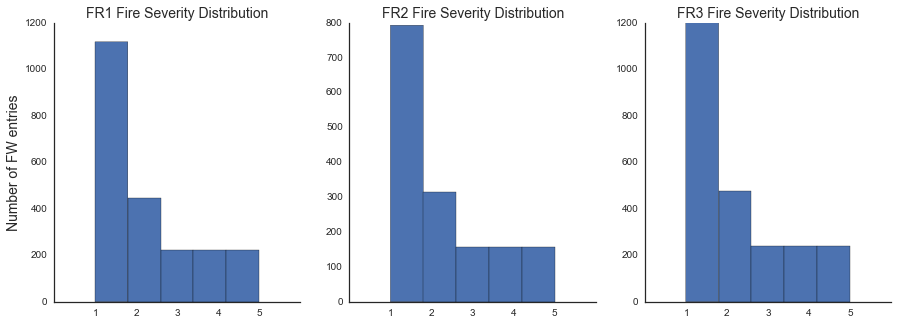

In [49]:
f, ax = plt.subplots(1,3, figsize =(15,5))
idx = 0
axs = f.axes
for Eco in np.unique(DinkeyFW_h.Ecoregion):
    ax = axs[idx]
    toPlot = DinkeyFW_h[DinkeyFW_h.Ecoregion == Eco]
    toPlot.FWIBin.hist(ax = ax, bins = 5)
    ax.set_title(Eco + ' Fire Severity Distribution', fontsize = 14)
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['','1','2','3','4','5',''])
    #ax.set_ylim([0,1100])
    ax.grid('off')
    if idx == 0:
        ax.set_ylabel('Number of FW entries', fontsize = 14)
    
    idx = idx + 1
sns.set_style('white')
sns.despine()

### Fires are not severe enough across the landscape
#### In an effort to understand why we are not getting the sorts of severe fires we might expect, we need to determine when those more severe fires (4 and 5) are occurring, with respect to the weather that generated them.

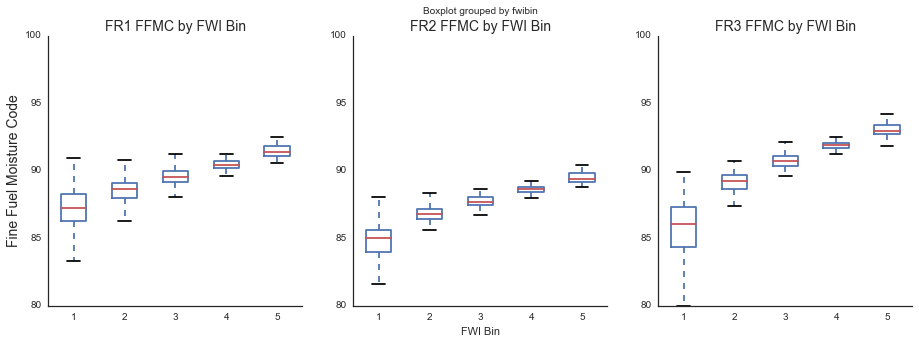

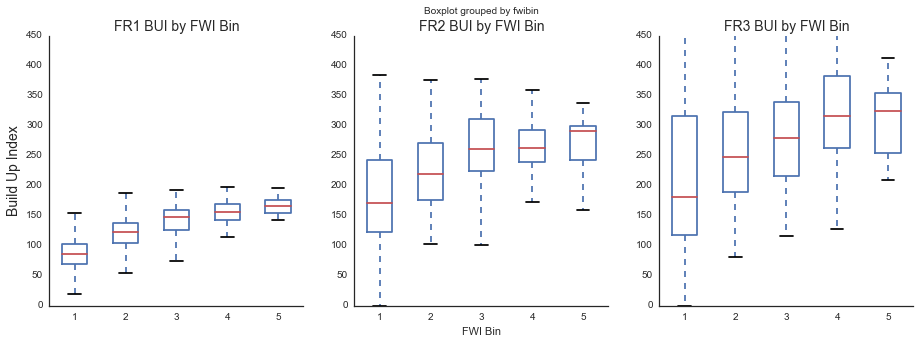

In [40]:
f, ax = plt.subplots(1,3, figsize =(15,5))
idx = 0
axs = f.axes
for Eco in np.unique(DinkeyFW_h.Ecoregion):
    ax = axs[idx]
    toPlot = DinkeyFW_h[DinkeyFW_h.Ecoregion == Eco]
    toPlotSub = pd.DataFrame(dict(ffmc = toPlot.FFMC, fwibin = toPlot.FWIBin))
    toPlotSub.boxplot(by='fwibin', ax = ax)
    ax.set_title(Eco + ' FFMC by FWI Bin', fontsize = 14)
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylim([80,100])
    ax.grid('off')
    if idx == 0:
        ax.set_ylabel('Fine Fuel Moisture Code', fontsize = 14)
    if idx == 1:
        ax.set_xlabel('FWI Bin')
    else:
        ax.set_xlabel('', fontsize = 14)
        
    idx = idx + 1
sns.set_style('white')
sns.despine()

f, ax = plt.subplots(1,3, figsize =(15,5))
idx = 0
axs = f.axes
for Eco in np.unique(DinkeyFW_h.Ecoregion):
    ax = axs[idx]
    toPlot = DinkeyFW_h[DinkeyFW_h.Ecoregion == Eco]
    toPlotSub = pd.DataFrame(dict(bui = toPlot.BUI, fwibin = toPlot.FWIBin))
    toPlotSub.boxplot(by='fwibin', ax = ax)
    ax.set_title(Eco + ' BUI by FWI Bin', fontsize = 14)
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_ylim([0,450])
    ax.grid('off')
    if idx == 0:
        ax.set_ylabel('Build Up Index', fontsize = 14)
    if idx == 1:
        ax.set_xlabel('FWI Bin')
    else:
        ax.set_xlabel('', fontsize = 14)
        
    idx = idx + 1
sns.set_style('white')
sns.despine()

### Generating 'Severe Fire weather'
#### We still do not have the weather sorted out properly for Dinkey such that the landscape occasionaly burns with high severity (severity 5) fire bins. Still sorting this out. In the meantime however, testing our 'Severe Fire Weather' input data seems reasonable just to keep on moving. Our first cut was to take data from the Rim fire and the Rough fire, and drive the fire weather based on those time series.

In [50]:
# Clean up RAWS raw data and generate FW inputs for the three fire regions

cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'FR1_RawsWeather.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR2_RawsWeather.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR3_RawsWeather.csv')

# Run Louise's script on the three fire regions input RAWS data.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeather.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region +'_FireWeather.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeather.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeather.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeather.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeySevereFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()


No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  237
No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  245
No. days being evaluated  365

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  247


FFMC  BUI  WSV  WINDDir  FWIBin
Ecoregion Season                                 
FR1       fall      29   29   29       29      29
          spring    19   19   19       19      19
          summer   189  189  189      189     189
FR2       fall      29   29   29       29      29
          spring    26   26   26       26      26
          summer   190  190  190      190     190
FR3       fall      29   29   29       29      29
          spring    28   28   28       28      28
          summer   190  190  190      190     190